# Предсказание температуры сплава для сталелитейного предприятия

Чтобы оптимизировать производственные расходы, металлургический комбинат «Стальная птица» решил уменьшить потребление электроэнергии на этапе обработки стали. Для этого комбинату нужно контролировать температуру сплава. Необходимо построить модель, которая будет её предсказывать. Заказчик хочет использовать разработанную модель для имитации технологического процесса.

**Цели исследования:**

* Изучить и обработать предоставленные данные.
* Обучить несколько моделей и выбрать лучшую модель для предсказания температуры сплава, удовлетворяющую запросу (показатель MAE не больше 6,8).
* Изучить важность признаков для модели, сделать рекомендации.

**Ход исследования:**

* Подготовка данных: загрузка и изучение информации о предоставленных датасетах.
* Предобработка данных: изменение типов данных, обработка дубликатов, пропусков, создание новых признаков.
* Исследовательский анализ данных: обработка выбросов и аномалий.
* Корреляционный анализ: определение взаимосвязи признаков.
* Обучение модели: подобрать лучший тип модели и её гиперпараметры.
* Анализ важности признаков: выявить наиболее и наименее важные признаки для модели.
* Вывод: сделать выводы о модели и их результатах работы, дать рекомендации.

<div class="alert alert-success" style="border-color: green; border-radius: 5px">
    <p><u><b>✅ КОММЕНТАРИЙ МЕНТОРА</b></u></p>
    <p>ок, это хороший тон - дать описание проблематики.</p>
</div>

## Подготовка данных

Импортируем библиотеки, объявляем константы

In [1]:
!pip install --upgrade scikit-learn -q

In [2]:
!pip install --upgrade lightgbm -q

In [3]:
!pip install shap -q

In [4]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import shap

from sklearn.model_selection import(
    train_test_split, RandomizedSearchCV)
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error

In [5]:
warnings.filterwarnings('ignore')

In [6]:
RANDOM_STATE = 220425
np.random.seed(220425)
TRAIN_TEST = 0.25

Загрузим данные, сразу зададим датам корректный тип данных, настроим показ всех столбцов, выведем информацию и первые строки

In [7]:
bulks = []
for i in range(1, 16):
    bulks.append('Bulk ' + str(i))
wires = []
for i in range(1, 10):
    wires.append('Wire ' + str(i))

In [8]:
pd.set_option('display.max_columns', None)

In [9]:
arc = pd.read_csv('datasets/data_arc_new.csv', parse_dates=['Начало нагрева дугой', 'Конец нагрева дугой'])
bulk = pd.read_csv('datasets/data_bulk_new.csv')
bulk_time =pd.read_csv('datasets/data_bulk_time_new.csv', parse_dates=bulks)
gas = pd.read_csv('datasets/data_gas_new.csv')
temp = pd.read_csv('datasets/data_temp_new.csv', parse_dates=['Время замера'])
wire = pd.read_csv('datasets/data_wire_new.csv')
wire_time = pd.read_csv('datasets/data_wire_time_new.csv', parse_dates=wires)

In [10]:
datasets = [arc, bulk, bulk_time, gas, temp, wire, wire_time]

In [11]:
for i in datasets:
    display(i.head(3))
    i.info()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   key                   14876 non-null  int64         
 1   Начало нагрева дугой  14876 non-null  datetime64[ns]
 2   Конец нагрева дугой   14876 non-null  datetime64[ns]
 3   Активная мощность     14876 non-null  float64       
 4   Реактивная мощность   14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaT,NaT,NaT,2019-05-03 11:28:48,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:24:31,NaT,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaT,NaT,NaT,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:53:30,NaT,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaT,NaT,NaT,2019-05-03 12:32:39,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:27:13,NaT,2019-05-03 12:21:01,2019-05-03 12:16:16


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   key      3129 non-null   int64         
 1   Bulk 1   252 non-null    datetime64[ns]
 2   Bulk 2   22 non-null     datetime64[ns]
 3   Bulk 3   1298 non-null   datetime64[ns]
 4   Bulk 4   1014 non-null   datetime64[ns]
 5   Bulk 5   77 non-null     datetime64[ns]
 6   Bulk 6   576 non-null    datetime64[ns]
 7   Bulk 7   25 non-null     datetime64[ns]
 8   Bulk 8   1 non-null      datetime64[ns]
 9   Bulk 9   19 non-null     datetime64[ns]
 10  Bulk 10  176 non-null    datetime64[ns]
 11  Bulk 11  177 non-null    datetime64[ns]
 12  Bulk 12  2450 non-null   datetime64[ns]
 13  Bulk 13  18 non-null     datetime64[ns]
 14  Bulk 14  2806 non-null   datetime64[ns]
 15  Bulk 15  2248 non-null   datetime64[ns]
dtypes: datetime64[ns](15), int64(1)
memory usage: 391.2 KB


,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           18092 non-null  int64         
 1   Время замера  18092 non-null  datetime64[ns]
 2   Температура   14665 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 424.2 KB


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
1,2,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
2,3,2019-05-03 12:11:46,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   key     3081 non-null   int64         
 1   Wire 1  3055 non-null   datetime64[ns]
 2   Wire 2  1079 non-null   datetime64[ns]
 3   Wire 3  63 non-null     datetime64[ns]
 4   Wire 4  14 non-null     datetime64[ns]
 5   Wire 5  1 non-null      datetime64[ns]
 6   Wire 6  73 non-null     datetime64[ns]
 7   Wire 7  11 non-null     datetime64[ns]
 8   Wire 8  19 non-null     datetime64[ns]
 9   Wire 9  29 non-null     datetime64[ns]
dtypes: datetime64[ns](9), int64(1)
memory usage: 240.8 KB


* Типы данных корректны
* В таблицах с работой печи и замерами температуры строчки соответствуют каждой отдельной итерации нагрева, требуется агрегирование
* Данные о времени добавления примесей бесполезны для нашего исследования, их можно не рассматривать
* В данных об обьеме добавок есть много пропусков в случаях, когда тот или иной материал не использовался. При этом некоторые материалы использовались всего раз за весь период сбора данных, для обучения такие единичные случаи бесполезны

## Предобработка данных

В таблице с данными о работе печи можно создать признаки с суммарной мощностью и длительностью каждого нагрева, после чего сагрегировать по ключу чтобы получить данные для целого обьекта исследования и найти суммарное время работы над одним сплавом

In [12]:
arc['Длительность нагрева'] = arc['Конец нагрева дугой'] - arc['Начало нагрева дугой']
arc['Длительность нагрева'] = arc['Длительность нагрева'].dt.total_seconds().astype(int)
arc['sum_power'] = arc['Активная мощность'] + arc['Реактивная мощность']
arc.head(6)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Длительность нагрева,sum_power
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,228,0.516383
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,185,1.243096
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,172,1.010773
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,365,0.898475
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,148,1.510824
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.381124,0.220351,137,0.601475


In [13]:
pivot_arc = arc.pivot_table(
    index='key', 
    values=['Длительность нагрева', 'Начало нагрева дугой', 'Конец нагрева дугой', 'sum_power'], 
    aggfunc={
             'Длительность нагрева': 'sum',
             'Конец нагрева дугой': 'max',
             'Начало нагрева дугой':  'min', 
             'sum_power': 'sum'
              })
pivot_arc.head(2)

,sum_power,Длительность нагрева,Конец нагрева дугой,Начало нагрева дугой
key,,,,
1,5.179551,1098,2019-05-03 11:28:37,2019-05-03 11:02:14
2,3.592765,811,2019-05-03 11:53:18,2019-05-03 11:34:14


In [14]:
pivot_arc = pivot_arc.reset_index(drop=False)
pivot_arc.columns = ['key', 'sum_power', 'time_heat', 'time_last', 'time_first']
pivot_arc.head(2)

,key,sum_power,time_heat,time_last,time_first
0,1,5.179551,1098,2019-05-03 11:28:37,2019-05-03 11:02:14
1,2,3.592765,811,2019-05-03 11:53:18,2019-05-03 11:34:14


In [15]:
pivot_arc['total_time'] = pivot_arc['time_last'] - pivot_arc['time_first']
pivot_arc['total_time'] = pivot_arc['total_time'].dt.total_seconds().astype(int)
pivot_arc = pivot_arc.drop(columns=['time_last', 'time_first'])
pivot_arc.head(2)

,key,sum_power,time_heat,total_time
0,1,5.179551,1098,1583
1,2,3.592765,811,1144


Данные о замерах температуры также стоит сагрегировать по ключу, взяв начальную температуру, которую мы знаем и можем использовать как входной признак, и финальную температуру, которая и является нашим целевым признаком

In [16]:
pivot_temp = temp.pivot_table(
    index='key', 
    values='Температура', 
    aggfunc={'Температура': [lambda x: x.iloc[0], lambda x: x.iloc[-1]]})
pivot_temp.head(2)

,<lambda_0>,<lambda_1>
key,,
1,1571.0,1613.0
2,1581.0,1602.0


In [17]:
pivot_temp = pivot_temp.reset_index(drop=False)
pivot_temp.columns = ['key', 'start_temp', 'target']
pivot_temp.head(2)

,key,start_temp,target
0,1,1571.0,1613.0
1,2,1581.0,1602.0


Из данных об обьеме сыпучих и проволочных примесей можно выделить признак суммарного обьема

In [18]:
bulk['sum_bulk'] = bulk[bulks].sum(axis=1)
bulk.head(2)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,sum_bulk
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0,553.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0,582.0


In [19]:
wire['sum_wire'] = wire[wires].sum(axis=1)
wire.head(2)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,sum_wire
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60.059998
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,96.052315


Присоединим получившиеся таблицы и таблицу с газом. Таблицы со временем добавления примесей нам не понадобятся, не будем их добавлять. Поскольку целевой признак находится в таблице с температурой, начнем с неё и будем использовать внутреннее соединение. Получим таблицу где во всех строчках будут данные о температуре, нагреве и добавках.

In [20]:
data = pd.merge(pivot_temp, pivot_arc, on='key', how='inner')
data = pd.merge(data, bulk, on='key', how='inner')
data = pd.merge(data, wire, on='key', how='inner')
data = pd.merge(data, gas, on='key', how='inner')
data.head(3)

,key,start_temp,target,sum_power,time_heat,total_time,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,sum_bulk,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,sum_wire,Газ 1
0,1,1571.0,1613.0,5.179551,1098,1583,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0,553.0,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60.059998,29.749986
1,2,1581.0,1602.0,3.592765,811,1144,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0,582.0,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,96.052315,12.555561
2,3,1596.0,1599.0,7.001098,655,1525,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0,544.0,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,91.160157,28.554793


In [21]:
data

,key,start_temp,target,sum_power,time_heat,total_time,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,sum_bulk,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,sum_wire,Газ 1
0,1,1571.0,1613.0,5.179551,1098,1583,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0,553.0,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60.059998,29.749986
1,2,1581.0,1602.0,3.592765,811,1144,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0,582.0,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,96.052315,12.555561
2,3,1596.0,1599.0,7.001098,655,1525,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0,544.0,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,91.160157,28.554793
3,4,1601.0,1625.0,4.763481,741,1093,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0,595.0,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,89.063515,18.841219
4,5,1576.0,1602.0,3.940941,869,1362,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0,584.0,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN,98.352796,5.413692
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3017,3237,1569.0,NaN,4.567289,909,1350,NaN,NaN,170.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,252.0,NaN,130.0,206.0,758.0,38.088959,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38.088959,5.543905
3018,3238,1584.0,NaN,2.412924,546,910,NaN,NaN,126.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,254.0,NaN,108.0,106.0,594.0,56.128799,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,56.128799,6.745669
3019,3239,1598.0,NaN,8.389546,1216,2930,NaN,NaN,NaN,NaN,NaN,114.0,NaN,NaN,NaN,NaN,NaN,158.0,NaN,270.0,88.0,630.0,143.357761,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,143.357761,16.023518
3020,3240,1617.0,NaN,5.691231,839,3524,NaN,NaN,NaN,NaN,NaN,26.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,192.0,54.0,272.0,34.070400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34.070400,11.863103


Проверим наличие явных дубликатов, удалим при необходимости. Выведем информацию о получившейся таблице

In [22]:
data.duplicated().sum()

0

In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3022 entries, 0 to 3021
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   key         3022 non-null   int64  
 1   start_temp  3022 non-null   float64
 2   target      2329 non-null   float64
 3   sum_power   3022 non-null   float64
 4   time_heat   3022 non-null   int32  
 5   total_time  3022 non-null   int32  
 6   Bulk 1      252 non-null    float64
 7   Bulk 2      22 non-null     float64
 8   Bulk 3      1293 non-null   float64
 9   Bulk 4      1012 non-null   float64
 10  Bulk 5      77 non-null     float64
 11  Bulk 6      570 non-null    float64
 12  Bulk 7      24 non-null     float64
 13  Bulk 8      1 non-null      float64
 14  Bulk 9      19 non-null     float64
 15  Bulk 10     176 non-null    float64
 16  Bulk 11     177 non-null    float64
 17  Bulk 12     2356 non-null   float64
 18  Bulk 13     18 non-null     float64
 19  Bulk 14     2709 non-null  

Удалим строчки с пропусками в таргете и столбцы с материалами, которые использовались всего раз. После этого выведем описание числовых данных

In [24]:
data = (data
        .dropna(subset=['target'])
        .drop(columns=['Bulk 8', 'Wire 5'])
       )

In [25]:
display(data.drop(columns='key').describe())

,start_temp,target,sum_power,time_heat,total_time,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,sum_bulk,Wire 1,Wire 2,Wire 3,Wire 4,Wire 6,Wire 7,Wire 8,Wire 9,sum_wire,Газ 1
count,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,199.000000,13.000000,960.000000,812.000000,53.000000,438.000000,13.000000,13.000000,143.000000,130.000000,1812.000000,14.000000,2068.000000,1699.000000,2329.000000,2306.000000,811.000000,39.000000,12.000000,45.000000,4.000000,13.000000,24.000000,2329.000000,2329.000000
mean,1586.718763,1593.365393,5.118653,807.647488,1992.304852,40.115578,254.846154,114.868750,106.995074,116.018868,119.269406,359.153846,79.692308,82.293706,76.053846,267.880795,177.571429,173.271277,164.432019,609.630313,103.465371,50.571346,193.182538,59.496235,50.659374,3.703414,55.772561,30.773167,125.208530,11.375600
std,28.290792,11.200915,15.002682,340.838388,1350.293931,18.226180,25.973853,77.485694,49.050943,95.189182,70.747953,208.804472,25.795299,27.788900,60.373554,125.588642,50.344527,64.009860,50.039060,287.599678,42.530971,39.755956,100.867783,30.804638,37.743040,3.818433,20.235591,15.210141,63.683386,6.392041
min,1191.000000,1541.000000,-711.329235,57.000000,57.000000,10.000000,228.000000,6.000000,13.000000,11.000000,17.000000,75.000000,63.000000,24.000000,8.000000,53.000000,151.000000,29.000000,1.000000,19.000000,1.918800,0.030160,0.144144,24.148801,0.137280,0.234208,45.076721,4.622800,1.918800,0.008399
25%,1571.000000,1587.000000,3.968624,581.000000,1324.000000,27.000000,242.000000,57.000000,73.000000,70.000000,72.000000,178.000000,66.000000,58.000000,25.000000,204.000000,153.250000,123.000000,105.000000,440.000000,75.042236,20.193680,93.189102,38.347402,25.053600,0.849004,46.002319,20.802601,89.013596,7.282948
50%,1587.000000,1593.000000,5.259210,778.000000,1744.000000,33.000000,248.000000,96.500000,105.000000,88.000000,100.000000,392.000000,68.000000,85.000000,60.000000,208.000000,154.500000,153.000000,200.000000,609.000000,102.053638,40.112801,236.972740,49.661561,40.085762,3.044704,46.187439,30.066399,116.101440,10.100950
75%,1603.000000,1598.000000,6.664035,993.000000,2397.000000,46.500000,258.000000,152.250000,136.250000,148.000000,155.750000,507.000000,71.000000,104.000000,105.500000,359.250000,158.500000,208.000000,205.000000,795.000000,128.220310,69.699761,277.068801,84.755579,65.036400,5.899114,46.279999,40.495001,151.568558,14.216688
max,1660.000000,1653.000000,21.324685,4189.000000,23485.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000,3235.000000,330.314424,282.780152,385.008668,113.231044,180.454575,8.490040,102.762401,62.025600,568.777664,77.995040


* Температура плавления должна быть выше 1400 градусов, удалим значения ниже
* В целевом признаке максимальное значение сильно выбивается из общего распределения
* В суммарной мощности присутствует отрицательное значение, оставим только положительные
* Добавки, инертный газ, время нагрева и особенно общее время имеют очень высокую дисперсию
* Пропуски обусловлены тем, что во время процесса не использовались те или иные материалы

Удалим строчки с отрицательной мощностью и слишком низкой температурой, заполним пропуски нулями, заменим в целочисленных столбцах тип данных на int

In [26]:
data = (data
        .query('sum_power > 0')
        .fillna(value=0)
        .query('start_temp >= 1400')
       )

In [27]:
for i in data.columns:
    if data[i].sum() == data[i].astype(int).sum():
        data[i] = data[i].astype(int)
    else:
        pass
data.dtypes

key             int32
start_temp      int32
target          int32
sum_power     float64
time_heat       int32
total_time      int32
Bulk 1          int32
Bulk 2          int32
Bulk 3          int32
Bulk 4          int32
Bulk 5          int32
Bulk 6          int32
Bulk 7          int32
Bulk 9          int32
Bulk 10         int32
Bulk 11         int32
Bulk 12         int32
Bulk 13         int32
Bulk 14         int32
Bulk 15         int32
sum_bulk        int32
Wire 1        float64
Wire 2        float64
Wire 3        float64
Wire 4        float64
Wire 6        float64
Wire 7        float64
Wire 8        float64
Wire 9        float64
sum_wire      float64
Газ 1         float64
dtype: object

Создадим столбец с рандомно сгенерированым признаком для дальнейшей проверки влияния входных признаков на модель

In [28]:
data['useless'] = np.random.randint(0, 100, size=len(data))

In [29]:
len(data)

2324

* Мы добавили новые признаки суммарной мощности, времени нагрева, общего времени, начальной температуры, суммарного обьема проволочных и сыпучих материалов, целевой признак финальной температуры;
* Cоединили таблицы по ключу с номером партии;
* Очистили данные от некорректных и бесполезных значений;
* Заполнили пропуски в обьеме добавок нулями;
* Задали целочисленный тип данных целым числам; 
* Создали бесполезный признак-индикатор. 

В результате получилось 2324 строк с готовыми к обучению данными

## Исследовательский анализ

Рассмотрим распределение целевого и входных признаков, не считая отдельные добавки

In [31]:
def dia_hist_box (col, title, xname, df=data):
    fig, (ax_box, ax_hist) = plt.subplots(
        2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}
    )
    sns.boxplot(x=df[col], orient="h", ax=ax_box)
    sns.histplot(data=df, x=col, ax=ax_hist)
    ax_box.set(xlabel='')
    ax_box.set_title(title)
    plt.xlabel(xname)
    plt.ylabel('Количество объектов')
    plt.grid(True)

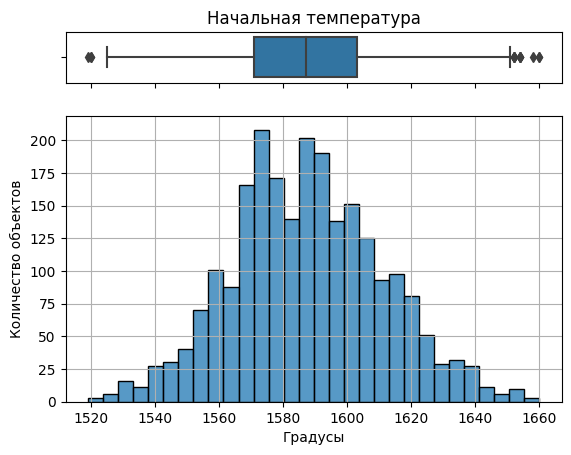

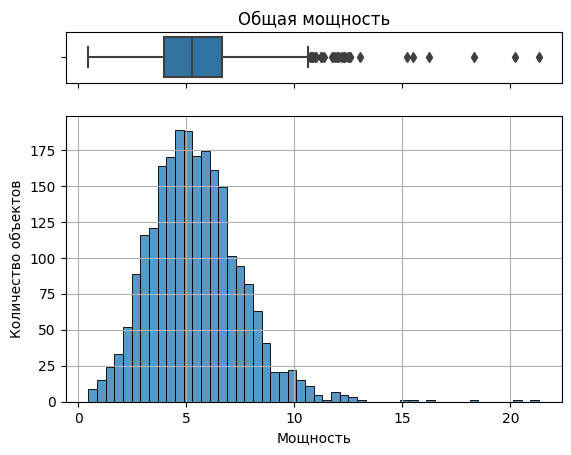

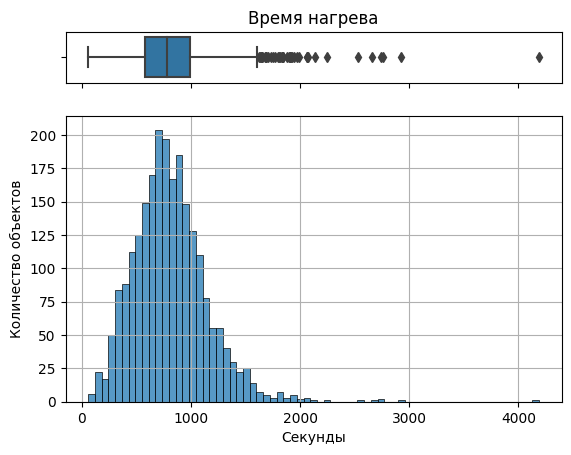

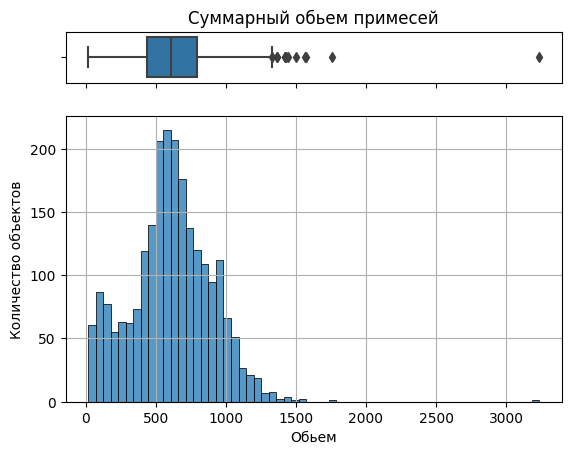

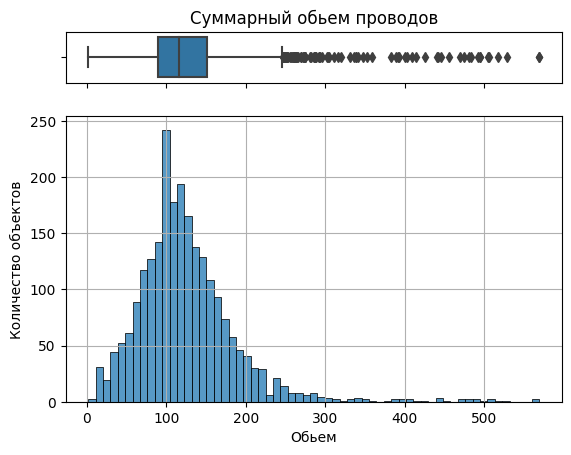

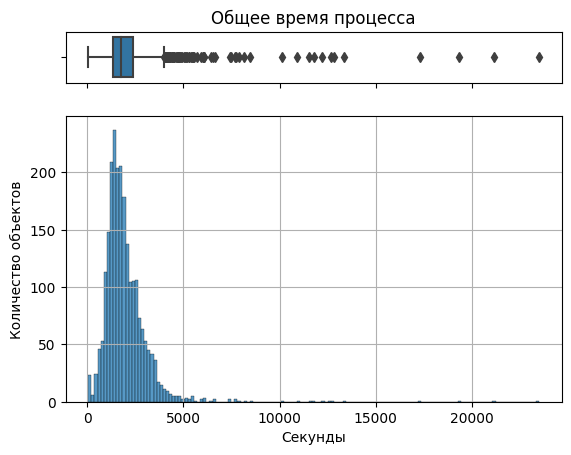

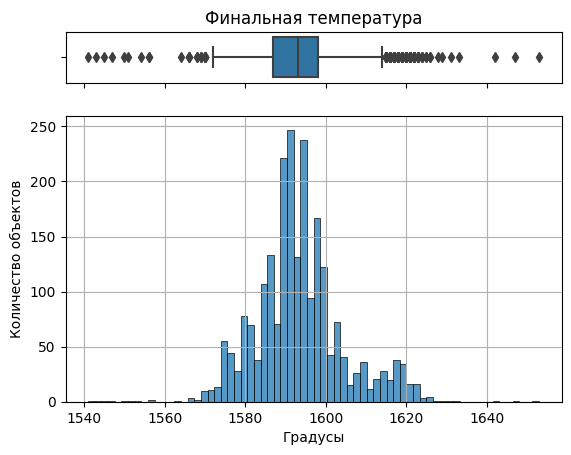

In [32]:
dia_hist_box('start_temp', 'Начальная температура', 'Градусы')
dia_hist_box('sum_power', 'Общая мощность', 'Мощность')
dia_hist_box('time_heat', 'Время нагрева', 'Секунды')
dia_hist_box('sum_bulk', 'Суммарный обьем примесей', 'Обьем')
dia_hist_box('sum_wire', 'Суммарный обьем проводов', 'Обьем')
dia_hist_box('total_time', 'Общее время процесса', 'Секунды')
dia_hist_box('target', 'Финальная температура', 'Градусы')

Данные распределены близко к нормальному, однако у всех признаков кроме начальной температурыимеется небольшое количество значений, которые сильно отклоняются в большую сторону. 

Кроме того, многие процессы проводились без добавок и в некоторых случаях общее время было очень маленьким

## Корреляционный анализ

Построим матрицу корреляций между всеми признаками кроме ключа. Используем метод Спирмена, поскольку не все признаки нормально распределены

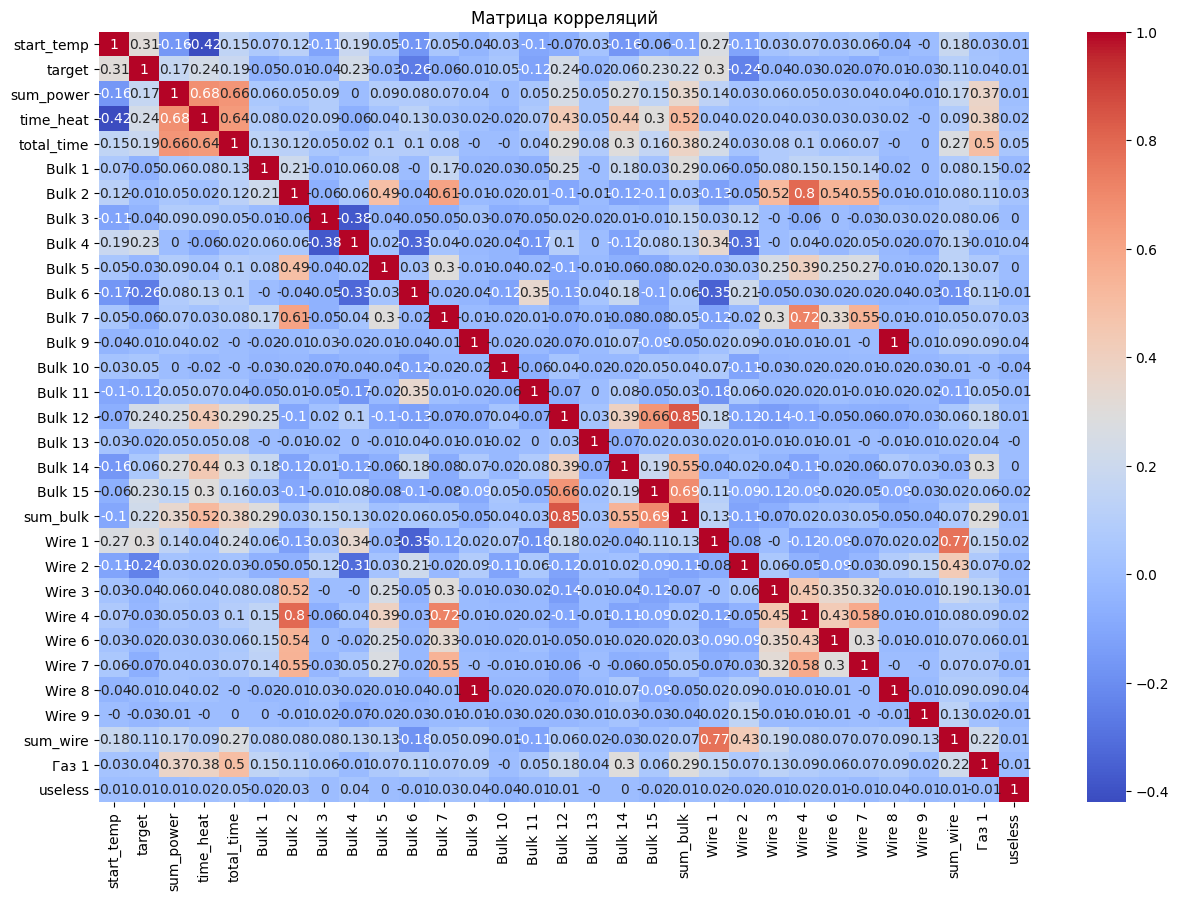

In [33]:
correlation_matrix = data.drop(columns='key').corr(method='spearman').round(2)
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Матрица корреляций')
plt.show()

Целевой признак имеет самую большую корреляцию со временем нагрева, начальной температурой и двумя добавками. В целом корреляция таргета с остальными признаками слабая, что может помешать линейным моделям.

Имеется прямая зависимость между двумя добавками, удалим одну из них

## Обучение модели

* Разделим данные на тренировочную и тестовую выборки.
* Валидировать модели будем с помощью кросс-валидации на 3 фолда.
* Целевой метрикой будет выступать MAE, необходимо получить менее 6,8.
* Поскольку входные признаки слабо коррелируют с таргетом, откажемся от линейных моделей. Рассмотрим метод ближайших соседей, дерево решений и градиентный бустинг.
* У нас нет категориальных признаков, а выбранные модели не требуют нормализации числовых данных, поэтому можем без предварительной подготовки сразу обучать модель.
* Подбирать гиперпараметры будем с помощью random search, для удобства создадим функцию. Поскольку у каждой модели разное количество комбинаций параметров, применять подбор будем для каждой отдельно.

In [34]:
X = data.drop(columns=['key', 'target', 'Wire 8'])
y = data['target']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TRAIN_TEST, random_state=RANDOM_STATE
)
display(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1743, 29)

(581, 29)

(1743,)

(581,)

In [35]:
def rs (estimator, params, X=X_train, y=y_train, niter=100):
    rand_search = RandomizedSearchCV(
        estimator, 
        params, 
        scoring='neg_mean_absolute_error',
        n_jobs=-1, 
        n_iter=niter, 
        random_state=RANDOM_STATE, 
        cv=3
    )
    rand_search.fit(X, y)
    print('Лучшая модель и её параметры:', rand_search.best_estimator_)
    print (
        'Метрика лучшей модели на кросс-валидации:', 
        rand_search.best_score_.round(4) * -1
    )
    return rand_search.best_estimator_

In [36]:
parameters_tree = {'max_depth': range(5, 35), 
              'max_features': range(5, 31), 
              'min_samples_leaf': range(3, 40)}

In [37]:
tree_model = rs(
    DecisionTreeRegressor(random_state=RANDOM_STATE), 
    parameters_tree, 
    niter=300
)

Лучшая модель и её параметры: DecisionTreeRegressor(max_depth=31, max_features=23, min_samples_leaf=26,
                      random_state=220425)
Метрика лучшей модели на кросс-валидации: 7.2303


Дерево решений не достигло требуемой метрики

In [38]:
parametrs_knn = {'n_neighbors': range(3, 50), 
              'leaf_size': range(2, 60, 2)}

In [39]:
knn_model = rs(
    KNeighborsRegressor(), 
    parametrs_knn, 
    niter=300
)

Лучшая модель и её параметры: KNeighborsRegressor(leaf_size=44, n_neighbors=18)
Метрика лучшей модели на кросс-валидации: 7.6888


Метод ближайших соседей также не достиг требуемой метрики, показав себя хуже дерева

In [40]:
parameters_lgb = {'num_leaves': range(3, 31), 
    'learning_rate': np.arange(0.01, 0.1, 0.01), 
    'n_estimators': range(200, 1001, 50), 
    'min_child_samples': range(10, 40)}

In [41]:
lgb_model = rs(
    lgb.LGBMRegressor(random_state=RANDOM_STATE, verbosity=-1), 
    parameters_lgb, 
    niter=400
)

Лучшая модель и её параметры: LGBMRegressor(learning_rate=0.09, min_child_samples=11, n_estimators=200,
              num_leaves=5, random_state=220425, verbosity=-1)
Метрика лучшей модели на кросс-валидации: 6.0189


Градиентный бустинг с запасом достиг требуемой метрики, проанализируем эту модель с помощью библиотеки SHAP

In [42]:
shap.initjs() 
X_summary = shap.sample(X_train, 30)

In [43]:
explainer = shap.KernelExplainer(
    lgb_model.predict, 
    X_summary, 
    keep_index=True
)
shap_values = explainer(X_train)

  0%|          | 0/1743 [00:00<?, ?it/s]

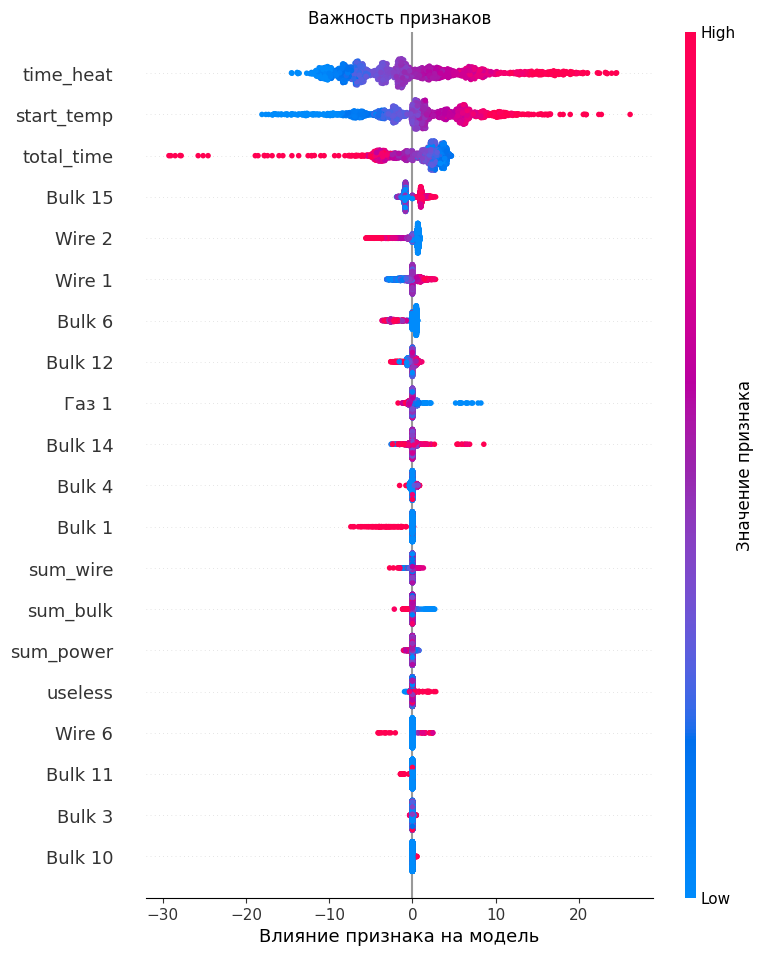

In [44]:
shap.summary_plot(shap_values, show=False)
fig, ax = plt.gcf(), plt.gca()
ax.set_xlabel("Влияние признака на модель")
ax.set_title('Важность признаков')
cb_ax = fig.axes[1] 
cb_ax.set_ylabel("Значение признака")
plt.show()

Самыми важными признаками оказались время нагрева, общее время процесса и начальная температура. Чем выше начальная температура, время нагрева, и ниже общее время процесса, тем выше итоговая температура, что выглядит логично. Некоторые признаки показали себя хуже рандомного, их можно смело удалить и уже без них заново обучить модель

In [45]:
data = data.drop(columns=['Bulk 5', 'Wire 6', 'Bulk 11', 'Bulk 3', 'sum_power', 'useless'])

In [46]:
X = data.drop(columns=['key', 'target', 'Wire 8'])
y = data['target']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TRAIN_TEST, random_state=RANDOM_STATE
)
display(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1743, 23)

(581, 23)

(1743,)

(581,)

In [47]:
lgb_model_small = rs(
    lgb.LGBMRegressor(random_state=RANDOM_STATE, verbosity=-1), 
    parameters_lgb, 
    X=X_train,
    y=y_train,
    niter=400
)

Лучшая модель и её параметры: LGBMRegressor(learning_rate=0.03, n_estimators=650, num_leaves=7,
              random_state=220425, verbosity=-1)
Метрика лучшей модели на кросс-валидации: 5.9618


Метрика не ухудшилась, можно приступать к тестированию

## Тестирование модели

Получим предсказания на тестовых данных, построим график остатков и выведем итоговую метрику MAE на тестовых данных

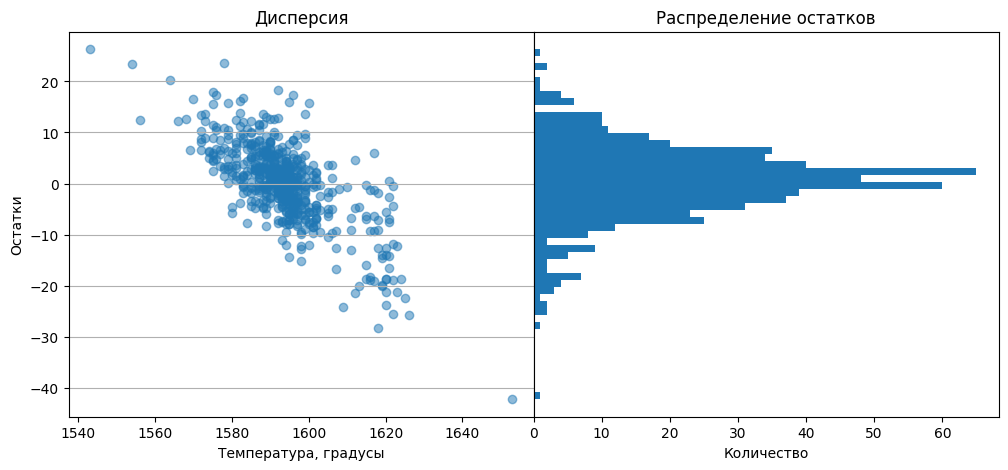

'MAE = 5.637'

In [48]:
predictions = lgb_model_small.predict(X_test)
residuals = predictions - y_test
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
plt.subplots_adjust(wspace=0)
axes[0].scatter(
    x=y_test, 
    y=residuals, 
    alpha=0.5)
axes[0].set_title('Дисперсия')
axes[0].set_xlabel('Температура, градусы')
axes[0].set_ylabel('Остатки')
axes[0].grid(True, axis='y')
axes[1].hist(x=residuals, bins=50, orientation='horizontal')
axes[1].set_title('Распределение остатков')
axes[1].set_xlabel('Количество')
axes[1].yaxis.set_visible(False)
plt.show()
mae = mean_absolute_error(y_test, predictions)
display(f"MAE = {mae:.3f}")

Метрика на тестовой выборке почти равна метрике на кросс-валидации, что означает надежность модели. 

Дисперсия ошибок для температуры от 1570 до 1610 градусов распределена одинаково вокруг нуля, в этом диапазоне модель работает особенно хорошо. Однако для процессов с большей и меньшей температурой ошибки увеличиваются.

## Выводы

**Предобработка и анализ данных**
* Для обучения модели предсказания температуры были получены 7 таблиц с различными данными о техническом процессе. Две из них оказались бесполезны для данного исследования.
* Из оставшихся пяти таблиц были извлечены необходимые данные, а также созданы новые признаки и выделен целевой признак финальной температуры, который и нужно предсказать.
* В данных присутствовали  некорректные значения и пропуски. Некорректные и бесполезные значения были удалены, пропуски логично заполнены.
* Для оценки важности признаков был создан бесполезный признак-индикатор. 
* В результате получилось 2324 строк с готовыми к обучению данными.
* Данные распределены близко к нормальному, однако у большинства признаков имеются сильно выбивающиеся в большую сторону значения. 
* Многие процессы проводились без добавок и в некоторых случаях общее время было очень маленьким.
* Целевой признак имеет слабую корреляцию со входными. Сильнее всего он связан со временем нагрева, начальной температурой и двумя добавками. 

**Обучение и тестирование моделей**
* Данные были разделены для обучения и теста. Проводилась кросс-валидации на 3 фолда.
* Для обучения были выбраны три модели: метод ближайших соседей, дерево решений и градиентный бустинг.
* Достичь целевой метрики смогла только одна модель LGBMRegressor
* После анализа признаков были исключены те, что показали себя хуже случайно сгенерированного. Уже без них модель была обучена заново.
* Для итогового обучения модели использовались следующие признаки: начальная температура, время нагрева, время процесса, обьем сыпучих добавок № 1, 2, 4, 6, 7, 9, 10, 12, 13, 14, 15,  суммарный обьем сыпучих добавок, обьем инертных газов, обьем проволочных материалов № 1, 2, 3, 4, 7, 8, 9, суммарный обьем проволочных материалов.
* В итоге для теста была выбрана модель LGBMRegressor со следующими параметрами: learning_rate=0.0699..., min_child_samples=27, n_estimators=600, num_leaves=4, random_state=220425
* Метрика этой модели на кросс-валидации составила 5.9618, что с запасом удовлетворяет требованиям.

**Тестирование и рекомендации**

На тесте MAE составила 5.637, что почти равно кросс-валидационной метрике и означает надежность модели. Самыми важными признаками оказались время нагрева, общее время процесса и начальная температура. Чем выше начальная температура, время нагрева, и ниже общее время процесса, тем выше итоговая температура. Другие факторы из предоставленных данных влияют слабо или вовсе не оказывают эффекта на конечную температуру. При предсказании средних температур от 1570 до 1610 градусов модель показывает себя особенно хорошо, однако при увеличении и уменьшении температуры модель начинает заметно ошибаться. Для исправления необходимо собрать больше данных о процессах с высокими и низкими температурами.